### Database manifestação

#### Pré processamento
Lidando com nomes próprios

In [11]:
import spacy
import nltk

nltk.download('stopwords')

nlp = spacy.load('pt_core_news_lg')
stopwords = set(nltk.corpus.stopwords.words('portuguese'))

# Mantem entidades, nomes próprios e de locais
def pre_processamento_ent(texto):
    doc = nlp(texto)  # mantém caixa original

    tokens = []
    ent_by_start = {ent.start: ent for ent in doc.ents}

    i = 0
    while i < len(doc):
        if i in ent_by_start:
            ent = ent_by_start[i]
            ent_text = ent.text
            if ent_text.lower() not in stopwords:  # compara versão minúscula
                tokens.append(ent_text)
            i = ent.end
        else:
            token = doc[i]
            if token.is_alpha and token.text.lower() not in stopwords:
                tokens.append(token.text)
            i += 1

    return tokens


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\luiza\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
import nltk
import re

nltk.download('stopwords')

def pre_processamento(texto):
  palavras = re.findall(r'\b[A-zÀ-úü]+\b', texto.lower())

  stopwords = nltk.corpus.stopwords.words('portuguese')
  sw = set(stopwords)

  palavras_filtradas = [i for i in palavras if i not in sw] # remove stopwords

#  return " ".join(palavras_filtradas)
  return palavras_filtradas

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\luiza\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Lidando com datas e termos como "20 mil pessoas"

In [1]:
import spacy
import nltk
from spacy.matcher import Matcher
from spacy.util import filter_spans

nltk.download('stopwords')

# Carrega modelo e stopwords
nlp = spacy.load('pt_core_news_lg')
stopwords = set(nltk.corpus.stopwords.words('portuguese'))

# Matcher para padrões como "20 mil pessoas" e datas
matcher = Matcher(nlp.vocab)
padrao_cardinal_substantivo = [
    {"LIKE_NUM": True},
    {"LOWER": {"IN": ["mil", "milhão", "milhões", "bilhão", "bilhões"]}, "OP": "?"},
    {"LOWER": "de", "OP": "?"},
    {"POS": "NOUN"}
]
padrao_num_extenso = [
    {"POS": "NUM"},
    {"LOWER": "de", "OP": "?"},
    {"POS": "NOUN"}
]
padrao_ordinal = [
    {"TAG": "ORD"},
    {"LOWER": "de", "OP": "?"},
    {"POS": "NOUN"}
]
matcher.add("NUM_UNIDADE", [padrao_cardinal_substantivo, padrao_num_extenso, padrao_ordinal])

def pre_processamento_ent_numeros(texto):
    doc = nlp(texto)

    # Identifica spans compostos (ex: "vinte mil pessoas")
    matches = matcher(doc)
    spans = [doc[start:end] for _, start, end in matches]
    spans_filtrados = filter_spans(spans)

    # Mapeia início do span -> span para evitar tokenização duplicada
    spans_dict = {span.start: span for span in spans_filtrados}
    ent_by_start = {ent.start: ent for ent in doc.ents}

    tokens = []
    i = 0
    while i < len(doc):
        if i in spans_dict:
            span = spans_dict[i]
            span_text = span.text
            if span_text.lower() not in stopwords:
                tokens.append(span_text)
            i = span.end
        elif i in ent_by_start:
            ent = ent_by_start[i]
            ent_text = ent.text
            if ent_text.lower() not in stopwords:
                tokens.append(ent_text)
            i = ent.end
        else:
            token = doc[i]
            if token.is_alpha and token.text.lower() not in stopwords:
                tokens.append(token.text)
            i += 1

    return tokens


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\luiza\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### Análise por notícia

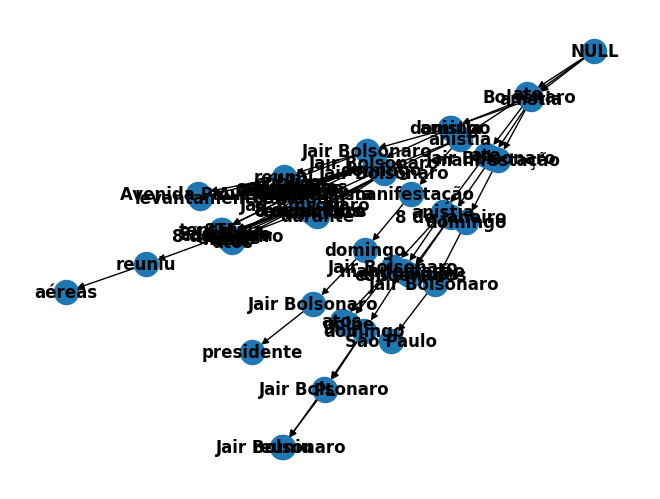

In [4]:
from trieofrules import trieofrules
import csv
import re

valores_coluna = []

with open('datasets/database_manifestacao_bolsonaro_pro_anistia.csv', encoding='utf-8') as f:
    reader = csv.DictReader(f)
    for line in reader:
      valores_coluna.append(line['Texto'])
      
valores = []
for texto in valores_coluna:
      result = pre_processamento_ent_numeros(texto)
      valores.append(result)

#supported algorithms: FP-max, FP-growth, Apriori
TOR_manifest = trieofrules(data = valores, alg='FP-max', min_support=0.55) 
TOR_manifest.draw()
TOR_manifest.save_graph(filename = 'outputs/manifest_noticias.graphml') 

In [38]:
#print('Sequências frequentes:')
#for i in TOR_manifest.frequent_sequences:
#    print(i)

print('\nTermos frequentes:')
for i in TOR_manifest.frequent_items:
    print(i)


Termos frequentes:
Bolsonaro
ato
anistia
manifestação
domingo
PL
Jair Bolsonaro
contagem
golpe
São Paulo
8 de janeiro
reuniu
condenados
disse
público
aéreas
atos
neste
imagens
STF
tentativa
USP
durante
prisão
Avenida Paulista
envolvidos
fotos
ter
Brasil
contra
presidente
mil
cerca
momento
pessoas
governador
democracia
ainda
levantamento
apoio
pico
Tarcísio de Freitas
Romeu Zema
Ronaldo Caiado
presos
golpistas
passado
Segundo
defesa
8 de Janeiro
governadores
perdão
erro
menos
União Brasil
projeto
pode
brasileiros
grupo
evento
sobre
decisão
direita
ano
Brasília


In [30]:
from nltk.text import Text
from nltk import word_tokenize


txt = " ".join(valores_coluna).lower()

#tokens = pre_processamento_ent(txt) #resultado fica sem stopwords
#token = tokens = word_tokenize(txt, language='english')
tokens = txt.split()
txt_manifest = Text(tokens)

palavra_mais_usada = next(iter(TOR_manifest.frequent_items)).lower() 
txt_manifest.concordance('bolsonaro')


Displaying 25 of 72 matches:
    o ato com o ex-presidente jair bolsonaro (pl) na avenida paulista neste dom
o de janeiro, também convocada por bolsonaro e aliados, reuniu cerca de 18,3 mi
ocracia. por volta das 15h40, jair bolsonaro discursou e pediu anistia para os 
sse que "eleições em 2026 sem jair bolsonaro é negar a democracia, é escancarar
 superior eleitoral (tse) condenou bolsonaro à inelegibilidade até 2030 por abu
midade tornar réus o ex-presidente bolsonaro e mais sete aliados por tentativa 
os. o ato com o ex-presidente jair bolsonaro (pl) e diversos aliados na avenida
tribunal superior eleitoral (tse), bolsonaro disse que “eleições em 26 sem jair
disse que “eleições em 26 sem jair bolsonaro é negar a democracia, é escancarar
ença de público, o comício de jair bolsonaro na avenida paulista pode ser class
overnadores de oposição ao lado de bolsonaro mostra o potencial de uma possível
te domingo pelo ex-presidente jair bolsonaro (pl) e o pastor silas malafaia na 
4, quando 1

In [36]:
import re

def concordance_termo(texto, termo, largura=40, case_sensitive=False):
    if not case_sensitive:
        texto_proc = texto.lower()
        termo_proc = termo.lower()
    else:
        texto_proc = texto
        termo_proc = termo

    ocorrencias = [m.start() for m in re.finditer(re.escape(termo_proc), texto_proc)]
    resultados = []

    for i in ocorrencias:
        inicio = max(0, i - largura)
        fim = min(len(texto), i + len(termo) + largura)

        esquerda = texto[inicio:i].replace('\n', ' ')
        centro = texto[i:i+len(termo)]
        direita = texto[i+len(termo):fim].replace('\n', ' ')

        # Calcula quantos espaços são necessários para alinhar o termo na coluna `largura`
        padding = largura - len(esquerda)
        padding = max(0, padding)

        linha = f"{' ' * padding}{esquerda}{centro}{direita}"
        resultados.append(linha)

    return resultados


In [40]:
txt = " ".join(valores_coluna).lower()

#resultados = concordance_termo(txt, "jair bolsonaro", largura=40)
resultados = concordance_termo(txt, "8 de janeiro", largura=40)

print(len(resultados))
for r in resultados:
    print(r)


29
a anistia aos envolvidos nos ataques de 8 de janeiro reuniu cerca de 44,9 mil manifestantes,
à anistia aos envolvidos nos ataques de 8 de janeiro de 2022, enquanto 34% defendem que o gr
 da anistia para envolvidos nos atos do 8 de janeiro, o monitoramento da usp contabilizou 18
ação é pela anistia dos condenados pelo 8 de janeiro, projeto de lei na câmara defendido por
 pelo pedido de anistia condenados pelo 8 de janeiro  45,7 mil em 7/09 de 2024 - protesto de
a invasão às sedes dos três poderes, em 8 de janeiro de 2023.  a estimativa é do monitor do 
 à paulista pedir anistia aos presos do 8 de janeiro, o ex-presidente reuniu cerca de 185 mi
 disseram preferir que os envolvidos no 8 de janeiro continuem presos, contra 34% que defend
a anistia aos condenados nos ataques de 8 de janeiro em brasília, o maior ataque às institui
 se não fosse isso, teria sido preso em 8 de janeiro "e estaria apodrecendo até hoje ou até 
à anistia aos envolvidos nos ataques de 8 de janeiro de 2022, enqua